In [1]:
import numpy as np
from itertools import permutations, combinations
import random
import time
import sys
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import networkx as nx
import math
from IPython.display import HTML

class VisualizedDeliveryProblemSolver:
    def __init__(self, adjacency_matrix, coordinates=None):
        """
        Khởi tạo với ma trận kề và tọa độ các điểm
        adjacency_matrix: ma trận vuông n×n
        coordinates: list of (x, y) tuples cho vị trí các điểm
        """
        self.matrix = np.array(adjacency_matrix, dtype=float)
        self.n = len(adjacency_matrix)

        # Chuyển đổi 0 thành infinity cho các cạnh không tồn tại
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.matrix[i][j] == 0:
                    self.matrix[i][j] = np.inf
                elif i == j:
                    self.matrix[i][j] = 0

        # Tạo tọa độ cho các điểm nếu không được cung cấp
        if coordinates is None:
            self.coordinates = self.generate_coordinates()
        else:
            self.coordinates = coordinates

    def generate_coordinates(self):
        """Tạo tọa độ ngẫu nhiên cho các điểm"""
        coordinates = []

        # Điểm 0 (kho) ở trung tâm
        coordinates.append((50, 50))

        # Các điểm khác phân bố ngẫu nhiên
        for i in range(1, self.n):
            # Tạo tọa độ trong hình tròn xung quanh trung tâm
            angle = 2 * math.pi * i / (self.n - 1)
            radius = random.uniform(20, 40)
            x = 50 + radius * math.cos(angle) + random.uniform(-5, 5)
            y = 50 + radius * math.sin(angle) + random.uniform(-5, 5)
            coordinates.append((x, y))

        return coordinates

    def print_matrix(self):
        """In ma trận kề"""
        print("Ma trận kề:")
        for i in range(self.n):
            row_str = ""
            for j in range(self.n):
                if self.matrix[i][j] == np.inf:
                    row_str += "∞".rjust(8)
                else:
                    row_str += f"{self.matrix[i][j]:.1f}".rjust(8)
            print(f"[{row_str} ]")
        print()

    def floyd_warshall(self):
        """Thuật toán Floyd-Warshall"""
        dist = self.matrix.copy()

        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    if dist[i][k] + dist[k][j] < dist[i][j]:
                        dist[i][j] = dist[i][k] + dist[k][j]

        return dist

    def is_strongly_connected(self):
        """Kiểm tra đồ thị có liên thông mạnh không"""
        for start in range(self.n):
            visited = [False] * self.n
            stack = [start]
            visited[start] = True
            count = 1

            while stack:
                curr = stack.pop()
                for next_vertex in range(self.n):
                    if not visited[next_vertex] and self.matrix[curr][next_vertex] != np.inf:
                        visited[next_vertex] = True
                        stack.append(next_vertex)
                        count += 1

            if count != self.n:
                return False
        return True

    def tsp_dynamic_programming(self):
        """TSP với Dynamic Programming"""
        if self.n > 20:
            return None, float('inf'), "Số điểm quá lớn cho DP (>20)"

        dist = self.floyd_warshall()
        dp = {}
        parent = {}

        for i in range(1, self.n):
            if dist[0][i] != np.inf:
                dp[(1 << i, i)] = dist[0][i]
                parent[(1 << i, i)] = 0

        for mask in range(1, 1 << self.n):
            for u in range(self.n):
                if not (mask & (1 << u)):
                    continue
                if (mask, u) not in dp:
                    continue

                for v in range(self.n):
                    if mask & (1 << v) or v == 0:
                        continue
                    if dist[u][v] == np.inf:
                        continue

                    new_mask = mask | (1 << v)
                    new_cost = dp[(mask, u)] + dist[u][v]

                    if (new_mask, v) not in dp or new_cost < dp[(new_mask, v)]:
                        dp[(new_mask, v)] = new_cost
                        parent[(new_mask, v)] = u

        final_mask = (1 << self.n) - 2
        min_cost = float('inf')
        last_vertex = -1

        for i in range(1, self.n):
            if (final_mask, i) in dp and dist[i][0] != np.inf:
                cost = dp[(final_mask, i)] + dist[i][0]
                if cost < min_cost:
                    min_cost = cost
                    last_vertex = i

        if last_vertex == -1:
            return None, float('inf'), "Không tìm được đường đi hợp lệ"

        path = []
        mask = final_mask
        curr = last_vertex

        while (mask, curr) in parent:
            path.append(curr)
            next_curr = parent[(mask, curr)]
            mask ^= (1 << curr)
            curr = next_curr

        path.append(0)
        path = path[::-1] + [0]

        return path, min_cost, "TSP DP hoàn thành"

    def tsp_nearest_neighbor(self, start=0):
        """Thuật toán Nearest Neighbor"""
        unvisited = set(range(self.n))
        current = start
        path = [current]
        total_cost = 0
        unvisited.remove(current)

        while unvisited:
            nearest = None
            min_dist = float('inf')

            for next_city in unvisited:
                if self.matrix[current][next_city] < min_dist:
                    min_dist = self.matrix[current][next_city]
                    nearest = next_city

            if nearest is None or min_dist == np.inf:
                return None, float('inf'), "Không tìm được đường đi hợp lệ"

            path.append(nearest)
            total_cost += min_dist
            current = nearest
            unvisited.remove(nearest)

        if self.matrix[current][start] != np.inf:
            path.append(start)
            total_cost += self.matrix[current][start]
            return path, total_cost, "Nearest Neighbor hoàn thành"
        else:
            return None, float('inf'), "Không thể quay về điểm ban đầu"

    def tsp_2opt(self, initial_path=None, max_iterations=1000):
        """Thuật toán 2-opt"""
        if initial_path is None:
            path, cost, msg = self.tsp_nearest_neighbor()
            if path is None:
                return None, float('inf'), "Không tìm được tour ban đầu"
        else:
            path = initial_path[:]
            cost = self.calculate_path_cost(path)

        improved = True
        iteration = 0

        while improved and iteration < max_iterations:
            improved = False
            iteration += 1

            for i in range(1, len(path) - 2):
                for j in range(i + 1, len(path) - 1):
                    new_path = path[:i] + path[i:j+1][::-1] + path[j+1:]
                    new_cost = self.calculate_path_cost(new_path)

                    if new_cost < cost:
                        path = new_path
                        cost = new_cost
                        improved = True
                        break

                if improved:
                    break

        return path, cost, f"2-opt hoàn thành sau {iteration} vòng lặp"

    def calculate_path_cost(self, path):
        """Tính chi phí của một đường đi"""
        if not path or len(path) < 2:
            return float('inf')

        total_cost = 0
        for i in range(len(path) - 1):
            cost = self.matrix[path[i]][path[i + 1]]
            if cost == np.inf:
                return float('inf')
            total_cost += cost

        return total_cost

    def visualize_graph(self, path=None, title="Bản đồ giao hàng", save_path=None):
        """Vẽ đồ thị với đường đi tối ưu"""
        plt.figure(figsize=(12, 10))

        # Vẽ tất cả các cạnh có thể đi
        for i in range(self.n):
            for j in range(self.n):
                if i != j and self.matrix[i][j] != np.inf:
                    x1, y1 = self.coordinates[i]
                    x2, y2 = self.coordinates[j]
                    plt.plot([x1, x2], [y1, y2], 'lightgray', linewidth=0.5, alpha=0.5)

        # Vẽ đường đi tối ưu nếu có
        if path:
            for i in range(len(path) - 1):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                plt.plot([x1, x2], [y1, y2], 'red', linewidth=3, alpha=0.8)

                # Vẽ mũi tên chỉ hướng
                dx, dy = x2 - x1, y2 - y1
                length = math.sqrt(dx**2 + dy**2)
                if length > 0:
                    dx, dy = dx/length, dy/length
                    mid_x, mid_y = (x1 + x2)/2, (y1 + y2)/2
                    plt.arrow(mid_x - dx*2, mid_y - dy*2, dx*4, dy*4,
                             head_width=1.5, head_length=1.5, fc='red', ec='red')

        # Vẽ các điểm
        for i, (x, y) in enumerate(self.coordinates):
            if i == 0:  # Kho hàng
                plt.scatter(x, y, c='green', s=200, marker='s', edgecolors='black', linewidth=2)
                plt.annotate(f'Kho {i}', (x, y), xytext=(5, 5),
                           textcoords='offset points', fontsize=10, fontweight='bold')
            else:  # Điểm giao hàng
                plt.scatter(x, y, c='blue', s=150, marker='o', edgecolors='black', linewidth=2)
                plt.annotate(f'Điểm {i}', (x, y), xytext=(5, 5),
                           textcoords='offset points', fontsize=9)

        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel('Tọa độ X', fontsize=12)
        plt.ylabel('Tọa độ Y', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.axis('equal')

        # Thêm chú thích
        legend_elements = [
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green',
                      markersize=10, label='Kho hàng'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                      markersize=8, label='Điểm giao hàng'),
            plt.Line2D([0], [0], color='red', linewidth=3, label='Đường đi tối ưu'),
            plt.Line2D([0], [0], color='lightgray', linewidth=1, label='Đường đi có thể')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    def animate_path(self, path, title="Animation đường đi giao hàng"):
        """Tạo animation cho đường đi"""
        if not path:
            return

        fig, ax = plt.subplots(figsize=(10, 8))

        def animate(frame):
            ax.clear()

            # Vẽ tất cả các điểm
            for i, (x, y) in enumerate(self.coordinates):
                if i == 0:
                    ax.scatter(x, y, c='green', s=200, marker='s',
                             edgecolors='black', linewidth=2)
                    ax.annotate(f'Kho {i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=10, fontweight='bold')
                else:
                    ax.scatter(x, y, c='blue', s=150, marker='o',
                             edgecolors='black', linewidth=2)
                    ax.annotate(f'Điểm {i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=9)

            # Vẽ đường đi đã đi qua
            for i in range(min(frame + 1, len(path) - 1)):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=3, alpha=0.8)

                # Vẽ mũi tên
                dx, dy = x2 - x1, y2 - y1
                length = math.sqrt(dx**2 + dy**2)
                if length > 0:
                    dx, dy = dx/length, dy/length
                    mid_x, mid_y = (x1 + x2)/2, (y1 + y2)/2
                    ax.arrow(mid_x - dx*2, mid_y - dy*2, dx*4, dy*4,
                            head_width=1.5, head_length=1.5, fc='red', ec='red')

            # Highlight điểm hiện tại
            if frame < len(path):
                x, y = self.coordinates[path[frame]]
                ax.scatter(x, y, c='yellow', s=300, marker='*', edgecolors='red', linewidth=3)

            ax.set_title(f"{title} - Bước {frame + 1}/{len(path)}", fontsize=14)
            ax.set_xlabel("Tọa độ X")
            ax.set_ylabel("Tọa độ Y")
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 100)
            ax.set_ylim(0, 100)
            ax.axis('equal')

        anim = FuncAnimation(fig, animate, frames=len(path),
                           interval=1000, repeat=False)
        try:
            from IPython.display import display
            display(HTML(anim.to_jshtml()))
        except:
            plt.show()

        return anim

    def compare_algorithms_visual(self):
        """So sánh trực quan các thuật toán"""
        algorithms = []
        results = []

        # Dynamic Programming
        if self.n <= 15:
            dp_path, dp_cost, dp_msg = self.tsp_dynamic_programming()
            if dp_path:
                algorithms.append("Dynamic Programming")
                results.append((dp_path, dp_cost))

        # Nearest Neighbor
        nn_path, nn_cost, nn_msg = self.tsp_nearest_neighbor()
        if nn_path:
            algorithms.append("Nearest Neighbor")
            results.append((nn_path, nn_cost))

        # 2-opt
        if nn_path:
            opt2_path, opt2_cost, opt2_msg = self.tsp_2opt(nn_path)
            if opt2_path:
                algorithms.append("2-opt")
                results.append((opt2_path, opt2_cost))

        # Vẽ so sánh
        n_algorithms = len(algorithms)
        if n_algorithms == 0:
            return

        fig, axes = plt.subplots(1, n_algorithms, figsize=(6*n_algorithms, 6))
        if n_algorithms == 1:
            axes = [axes]

        for idx, (alg_name, (path, cost)) in enumerate(zip(algorithms, results)):
            ax = axes[idx]

            # Vẽ các cạnh có thể
            for i in range(self.n):
                for j in range(self.n):
                    if i != j and self.matrix[i][j] != np.inf:
                        x1, y1 = self.coordinates[i]
                        x2, y2 = self.coordinates[j]
                        ax.plot([x1, x2], [y1, y2], 'lightgray', linewidth=0.5, alpha=0.3)

            # Vẽ đường đi
            for i in range(len(path) - 1):
                x1, y1 = self.coordinates[path[i]]
                x2, y2 = self.coordinates[path[i + 1]]
                ax.plot([x1, x2], [y1, y2], 'red', linewidth=2)

            # Vẽ các điểm
            for i, (x, y) in enumerate(self.coordinates):
                if i == 0:
                    ax.scatter(x, y, c='green', s=150, marker='s', edgecolors='black')
                    ax.annotate(f'{i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=8)
                else:
                    ax.scatter(x, y, c='blue', s=100, marker='o', edgecolors='black')
                    ax.annotate(f'{i}', (x, y), xytext=(5, 5),
                              textcoords='offset points', fontsize=8)

            ax.set_title(f'{alg_name}\nChi phí: {cost:.2f}', fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.axis('equal')

        plt.tight_layout()
        plt.show()

    def find_eulerian_cycle(self):
        """Tìm chu trình Euler nếu tồn tại (đồ thị vô hướng)"""
        from collections import defaultdict, Counter

        degree = [0] * self.n
        graph = defaultdict(list)

        # Xây dựng đồ thị vô hướng
        for i in range(self.n):
            for j in range(i + 1, self.n):  # Chỉ duyệt nửa trên vì vô hướng
                if self.matrix[i][j] != np.inf:
                    graph[i].append(j)
                    graph[j].append(i)
                    degree[i] += 1
                    degree[j] += 1

        # Kiểm tra điều kiện Euler: tất cả bậc chẵn
        if not all(d % 2 == 0 for d in degree):
            return None, "Không tồn tại chu trình Euler: có đỉnh bậc lẻ"

        # Tạo bản sao đồ thị dùng Counter để xử lý đa cạnh (nếu có)
        local_graph = {u: Counter(v) for u, v in graph.items()}
        path = []
        stack = [0]

        while stack:
            u = stack[-1]
            if local_graph[u]:
                v = next(iter(local_graph[u]))
                stack.append(v)

                # Giảm số lần xuất hiện (xóa cạnh u-v và v-u)
                local_graph[u][v] -= 1
                if local_graph[u][v] == 0:
                    del local_graph[u][v]

                local_graph[v][u] -= 1
                if local_graph[v][u] == 0:
                    del local_graph[v][u]
            else:
                path.append(stack.pop())

        total_edges = sum(degree) // 2
        if len(path) == total_edges + 1:
            return path[::-1], "Chu trình Euler tìm được thành công"
        else:
            return None, "Không tìm được chu trình Euler đầy đủ"


    def find_hamiltonian_cycle(self):
        """Tìm chu trình Hamilton nếu tồn tại (độ phức tạp cao)"""
        path = [0]
        visited = [False] * self.n
        visited[0] = True

        def backtrack(pos):
            if len(path) == self.n:
                if self.matrix[path[-1]][path[0]] != np.inf:
                    path.append(0)
                    return True
                return False

            for next_node in range(1, self.n):
                if not visited[next_node] and self.matrix[pos][next_node] != np.inf:
                    path.append(next_node)
                    visited[next_node] = True
                    if backtrack(next_node):
                        return True
                    visited[next_node] = False
                    path.pop()
            return False

        if backtrack(0):
            return path, "Chu trình Hamilton tìm được thành công"
        else:
            return None, "Không tồn tại chu trình Hamilton"

    def solve_and_visualize(self):
        """Giải bài toán và tạo trực quan hóa"""
        print("=" * 70)
        print("GIẢI BÀI TOÁN GIAO HÀNG VỚI TRỰC QUAN HÓA")
        print("=" * 70)

        self.print_matrix()
        print(f"Số điểm giao hàng: {self.n}")
        print()

        # Vẽ đồ thị ban đầu
        print("1. Vẽ bản đồ ban đầu...")
        self.visualize_graph(title="Bản đồ các điểm giao hàng")

        # Tìm giải pháp tối ưu
        best_path = None
        best_cost = float('inf')
        best_algorithm = ""

        print("2. Tìm đường đi tối ưu...")

        # Dynamic Programming
        if self.n <= 15:
            dp_path, dp_cost, dp_msg = self.tsp_dynamic_programming()
            print(f"Dynamic Programming: {dp_msg}")
            if dp_path and dp_cost < best_cost:
                best_path, best_cost, best_algorithm = dp_path, dp_cost, "Dynamic Programming"

        # Nearest Neighbor + 2-opt
        nn_path, nn_cost, nn_msg = self.tsp_nearest_neighbor()
        print(f"Nearest Neighbor: {nn_msg}")

        if nn_path:
            opt2_path, opt2_cost, opt2_msg = self.tsp_2opt(nn_path)
            print(f"2-opt: {opt2_msg}")

            if opt2_path and opt2_cost < best_cost:
                best_path, best_cost, best_algorithm = opt2_path, opt2_cost, "2-opt"

        # Vẽ kết quả
        if best_path:
            print(f"\n3. Kết quả tốt nhất: {best_algorithm}")
            print(f"Đường đi: {' -> '.join(map(str, best_path))}")
            print(f"Chi phí: {best_cost:.2f}")

            # Vẽ bản đồ với đường đi tối ưu
            self.visualize_graph(best_path,
                               f"Đường đi tối ưu ({best_algorithm}) - Chi phí: {best_cost:.2f}")

            # Tạo animation
            print("\n4. Tạo animation đường đi...")
            anim = solver.animate_path(best_path)
            HTML(anim.to_jshtml())

            # So sánh các thuật toán
            print("\n5. So sánh các thuật toán...")
            self.compare_algorithms_visual()

        # Kiểm tra chu trình Euler
        print("\n4. Kiểm tra chu trình Euler (vô hướng)...")
        euler_path, euler_msg = self.find_eulerian_cycle()
        print(f"Chu trình Euler: {euler_msg}")
        if euler_path:
            print(" -> ".join(map(str, euler_path)))
            self.visualize_graph(euler_path, title="Chu trình Euler")

        # Kiểm tra và in chu trình Hamilton
        print("\n7. Kiểm tra chu trình Hamilton...")
        hamilton_path, hamilton_msg = self.find_hamiltonian_cycle()
        print(f"Chu trình Hamilton: {hamilton_msg}")
        if hamilton_path:
            print(" -> ".join(map(str, hamilton_path)))
        self.visualize_graph(hamilton_path, title="Chu trình Hamilton")

        return best_path, best_cost, best_algorithm


def create_matrix_from_coordinates(coordinates, distance_factor=1.0):
    """Tạo ma trận khoảng cách từ tọa độ"""
    n = len(coordinates)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                x1, y1 = coordinates[i]
                x2, y2 = coordinates[j]
                distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2) * distance_factor
                matrix[i][j] = distance

    return matrix.tolist()


def demo_examples_with_visualization():
    """Các ví dụ demo có trực quan hóa"""
    print("CHỌN VÍ DỤ DEMO VỚI TRỰC QUAN HÓA:")
    print("1. Ví dụ thành phố nhỏ (5 điểm)")
    print("2. Ví dụ khu vực giao hàng (8 điểm)")
    print("3. Ví dụ thành phố lớn (12 điểm)")
    print("4. Tạo bản đồ ngẫu nhiên")
    print("5. Nhập tọa độ tự định")

    choice = input("Chọn (1-5): ")

    if choice == "1":
        # Ví dụ thành phố nhỏ
        coordinates = [(50, 50), (30, 70), (70, 80), (80, 30), (20, 20)]
        matrix = create_matrix_from_coordinates(coordinates)
        print("Tạo bản đồ thành phố nhỏ 5 điểm")

    elif choice == "2":
        # Ví dụ khu vực giao hàng
        coordinates = [
            (50, 50),   # Kho
            (30, 70), (70, 80), (80, 30), (20, 20),
            (60, 60), (40, 40), (90, 60)
        ]
        matrix = create_matrix_from_coordinates(coordinates)
        print("Tạo bản đồ khu vực giao hàng 8 điểm")

    elif choice == "3":
        # Ví dụ thành phố lớn
        coordinates = [
            (50, 50),   # Kho trung tâm
            (20, 80), (40, 90), (60, 85), (80, 75),
            (90, 50), (85, 25), (65, 15), (35, 20),
            (15, 40), (25, 60), (75, 40)
        ]
        matrix = create_matrix_from_coordinates(coordinates)
        print("Tạo bản đồ thành phố lớn 12 điểm")

    elif choice == "4":
        n = int(input("Nhập số điểm (5-20): "))
        # Tạo tọa độ ngẫu nhiên
        coordinates = [(50, 50)]  # Kho ở trung tâm
        for i in range(1, n):
            angle = 2 * math.pi * random.random()
            radius = random.uniform(15, 45)
            x = 50 + radius * math.cos(angle) + random.uniform(-10, 10)
            y = 50 + radius * math.sin(angle) + random.uniform(-10, 10)
            coordinates.append((x, y))

        matrix = create_matrix_from_coordinates(coordinates)
        print(f"Tạo bản đồ ngẫu nhiên {n} điểm")

    else:
        n = int(input("Nhập số điểm: "))
        coordinates = []
        print("Nhập tọa độ các điểm:")
        for i in range(n):
            x = float(input(f"Tọa độ X của điểm {i}: "))
            y = float(input(f"Tọa độ Y của điểm {i}: "))
            coordinates.append((x, y))

        matrix = create_matrix_from_coordinates(coordinates)
        print(f"Tạo bản đồ từ {n} điểm tự định")

    return matrix, coordinates



ModuleNotFoundError: No module named 'networkx'

CHƯƠNG TRÌNH GIẢI BÀI TOÁN GIAO HÀNG VỚI TRỰC QUAN HÓA
Sử dụng matplotlib để vẽ bản đồ và animation

CHỌN VÍ DỤ DEMO VỚI TRỰC QUAN HÓA:
1. Ví dụ thành phố nhỏ (5 điểm)
2. Ví dụ khu vực giao hàng (8 điểm)
3. Ví dụ thành phố lớn (12 điểm)
4. Tạo bản đồ ngẫu nhiên
5. Nhập tọa độ tự định
Chọn (1-5): 1
Tạo bản đồ thành phố nhỏ 5 điểm
GIẢI BÀI TOÁN GIAO HÀNG VỚI TRỰC QUAN HÓA
Ma trận kề:
[     0.0    28.3    36.1    36.1    42.4 ]
[    28.3     0.0    41.2    64.0    51.0 ]
[    36.1    41.2     0.0    51.0    78.1 ]
[    36.1    64.0    51.0     0.0    60.8 ]
[    42.4    51.0    78.1    60.8     0.0 ]

Số điểm giao hàng: 5

1. Vẽ bản đồ ban đầu...


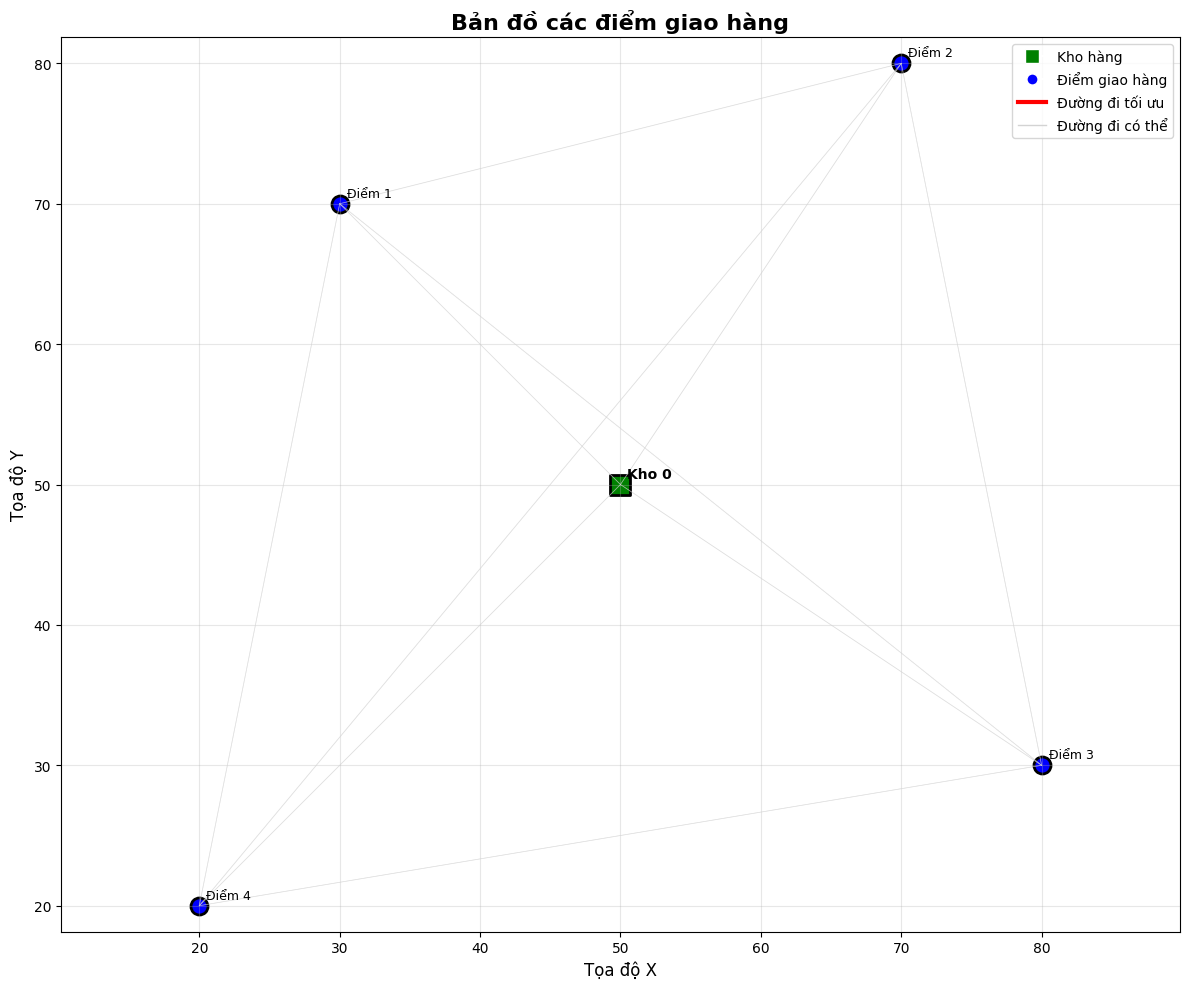

2. Tìm đường đi tối ưu...
Dynamic Programming: TSP DP hoàn thành
Nearest Neighbor: Nearest Neighbor hoàn thành
2-opt: 2-opt hoàn thành sau 2 vòng lặp

3. Kết quả tốt nhất: Dynamic Programming
Đường đi: 0 -> 4 -> 1 -> 2 -> 3 -> 0
Chi phí: 221.69


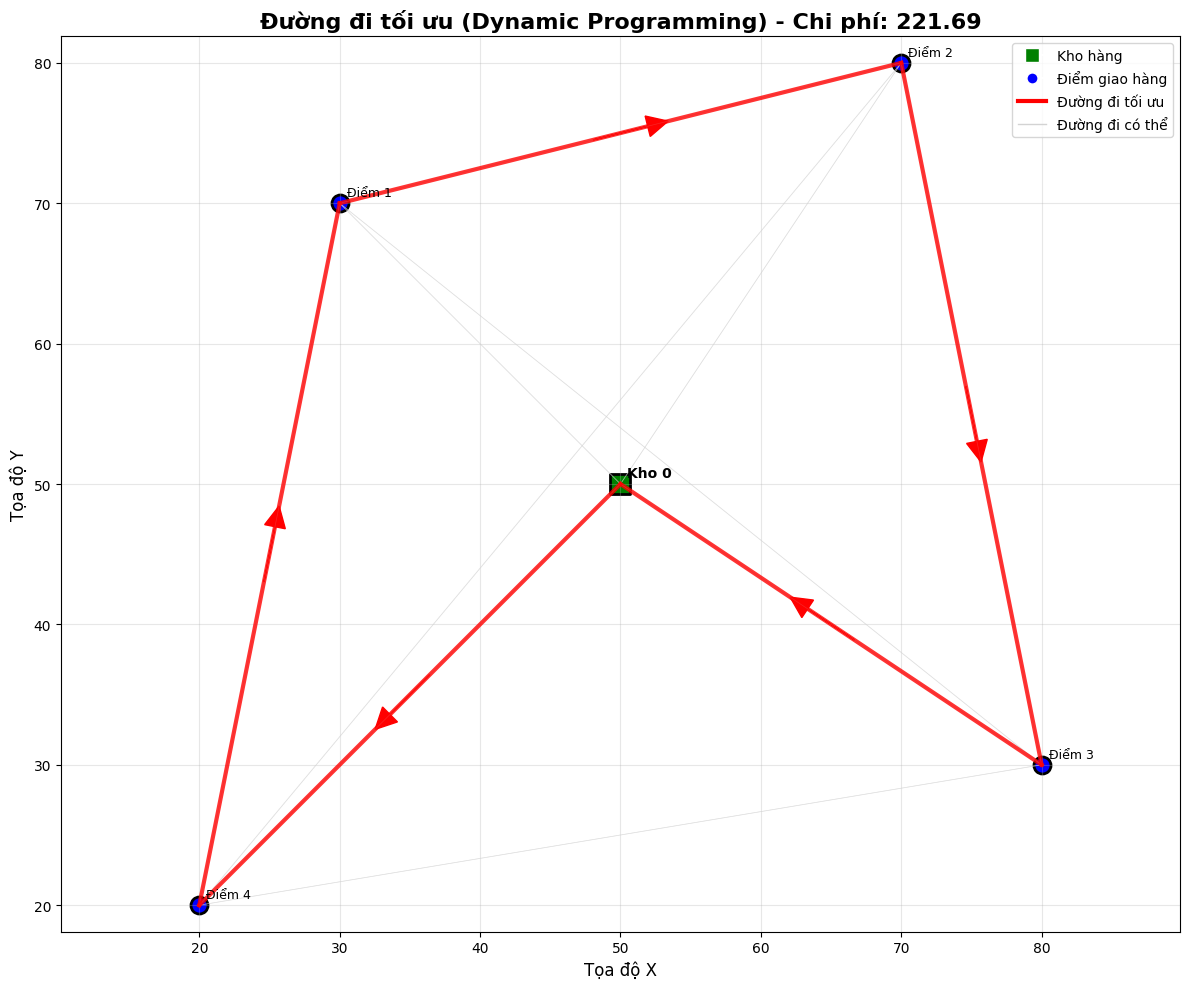


4. Tạo animation đường đi...



5. So sánh các thuật toán...


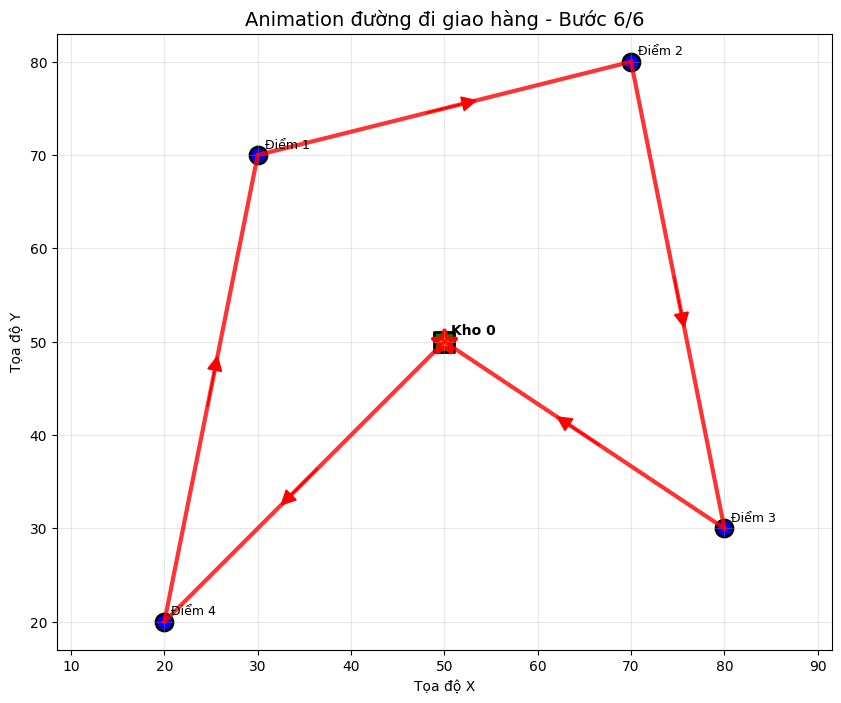

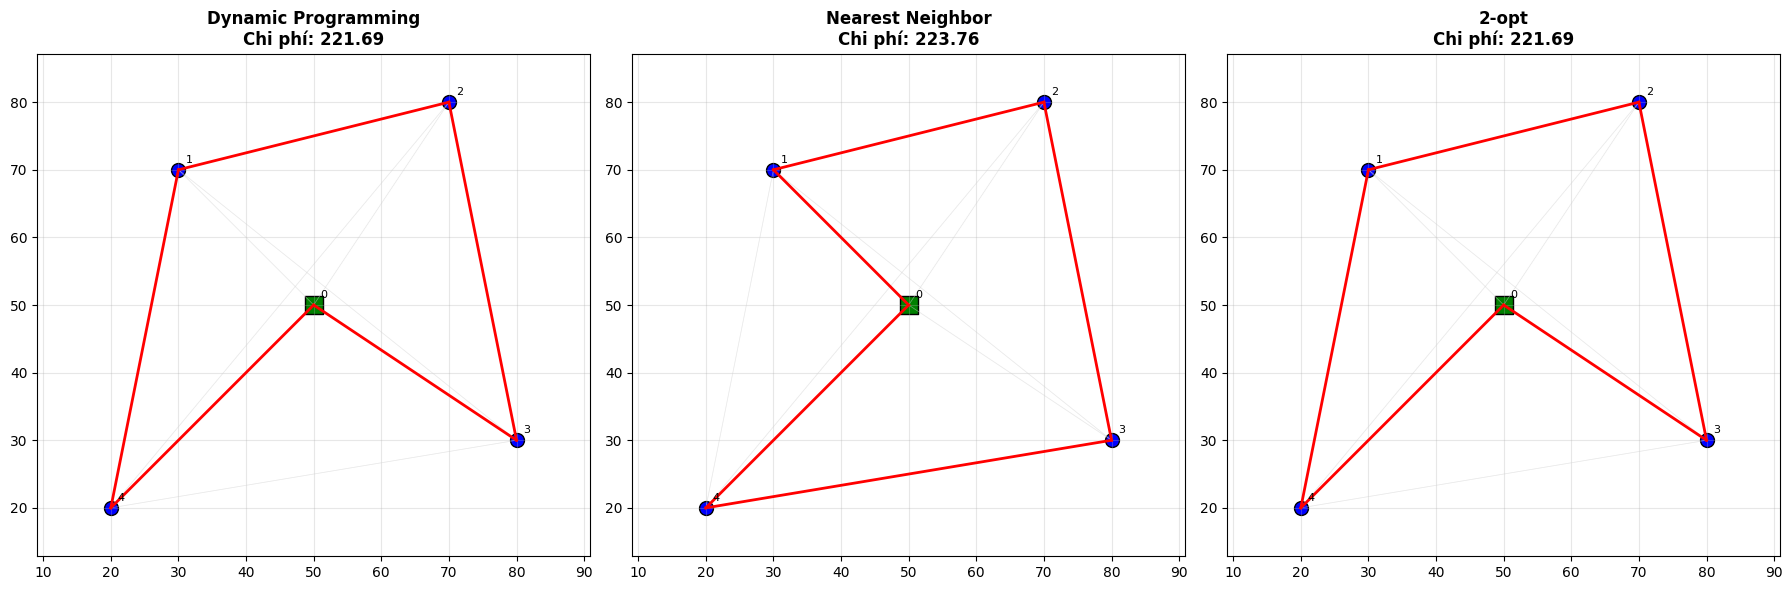


4. Kiểm tra chu trình Euler (vô hướng)...
Chu trình Euler: Chu trình Euler tìm được thành công
0 -> 1 -> 2 -> 0 -> 3 -> 1 -> 4 -> 2 -> 3 -> 4 -> 0


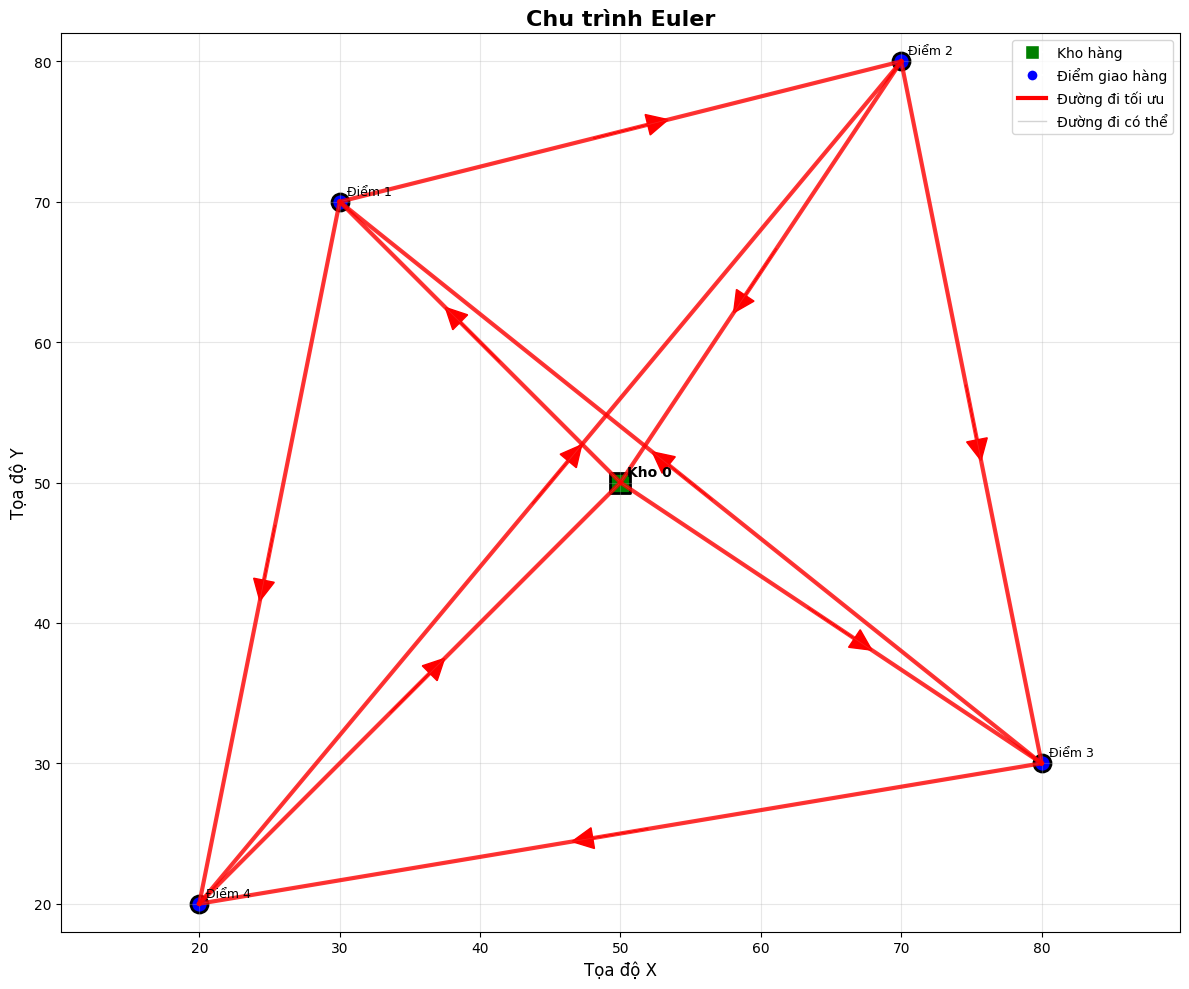


7. Kiểm tra chu trình Hamilton...
Chu trình Hamilton: Chu trình Hamilton tìm được thành công
0 -> 1 -> 2 -> 3 -> 4 -> 0


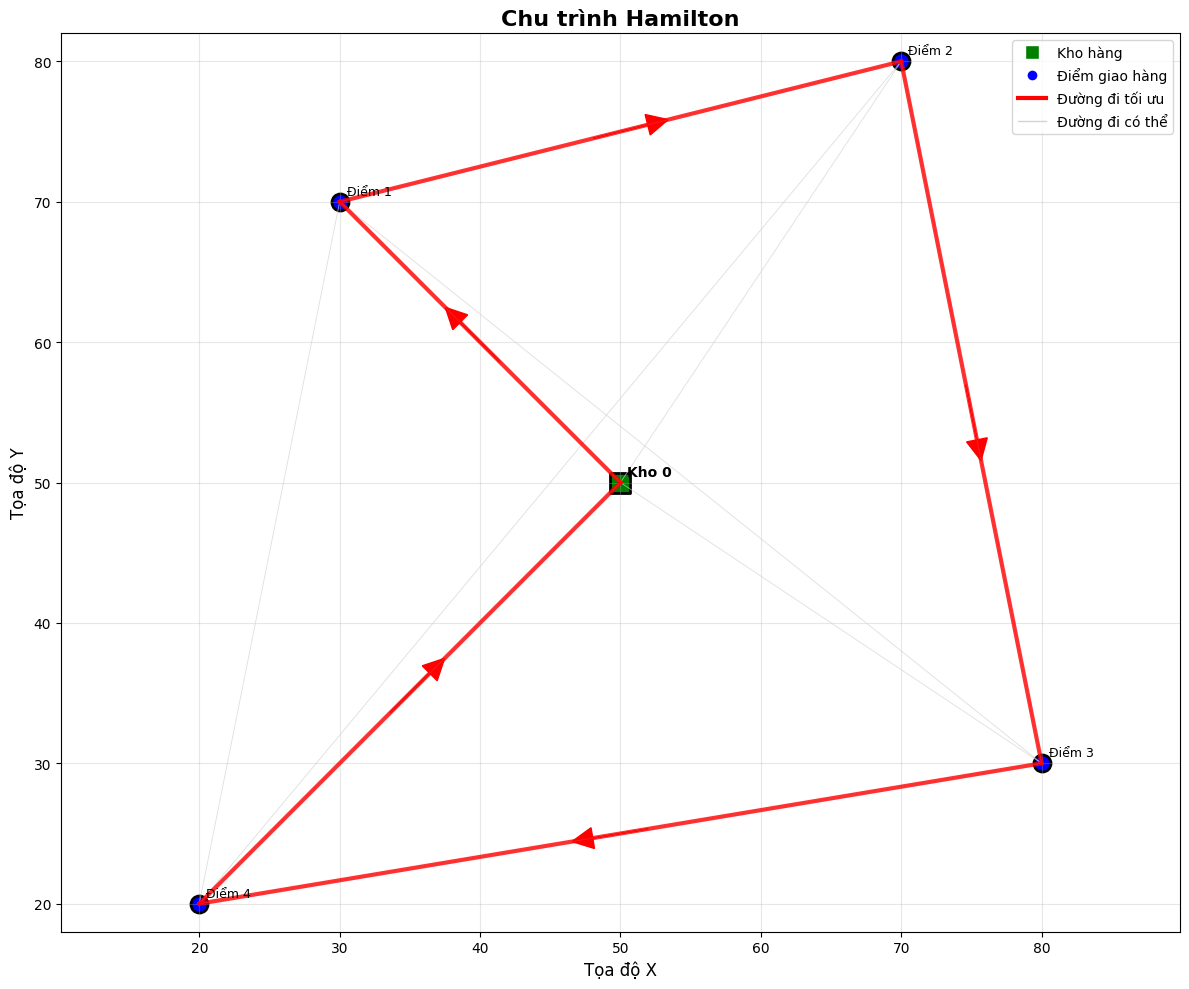


🎯 Kết quả cuối cùng:
Thuật toán tốt nhất: Dynamic Programming
Chi phí tối thiểu: 221.69
Đường đi: 0 -> 4 -> 1 -> 2 -> 3 -> 0


In [ ]:
if __name__ == "__main__":
    try:
        print("CHƯƠNG TRÌNH GIẢI BÀI TOÁN GIAO HÀNG VỚI TRỰC QUAN HÓA")
        print("Sử dụng matplotlib để vẽ bản đồ và animation")
        print()
        38
        # Lấy dữ liệu đầu vào
        adjacency_matrix, coordinates = demo_examples_with_visualization()

        # Tạo solver và giải với trực quan
        solver = VisualizedDeliveryProblemSolver(adjacency_matrix, coordinates)
        best_path, best_cost, best_algorithm = solver.solve_and_visualize()

        print(f"\n🎯 Kết quả cuối cùng:")
        print(f"Thuật toán tốt nhất: {best_algorithm}")
        print(f"Chi phí tối thiểu: {best_cost:.2f}")
        print(f"Đường đi: {' -> '.join(map(str, best_path)) if best_path else 'Không tìm được'}")

    except KeyboardInterrupt:
        print("\nChương trình bị dừng bởi người dùng")
    except Exception as e:
        print(f"Lỗi: {e}")
        import traceback
        traceback.print_exc()